# Prediction Metrics

For PeTaL Labeller Issue #42 (https://github.com/nasa-petal/PeTaL-labeller/issues/42), a start to analyzing precision, recall, &c., of MATCH.

In [ ]:
!pip3 install --upgrade scikit-learn

     |████████████████████████████████| 22.3 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix

from collections import namedtuple
from tqdm import tqdm

In [ ]:
# If running on Google Colab: Mount drive and cd to workspace.
from google.colab import drive
drive.mount('/content/drive')

# IMPORTANT: Replace DRIVE_PATH with the path you plan to clone MATCH into.
# If you are in the PeTaL Drive and your PeTAL link is under MyDrive/
# then the following DRIVE_PATH should work fine?
# DRIVE_PATH = '/content/drive/MyDrive/PeTaL/PeTaL Data/MATCH on PeTaL Data/'
DRIVE_PATH = '/content/drive/Shareddrives/NASA'
%cd $DRIVE_PATH

Mounted at /content/drive
/content/drive/Shareddrives/NASA


In [ ]:
if not os.path.exists('MATCH/'):
    !git clone https://github.com/yuzhimanhua/MATCH.git
else:
    print("You have already cloned the MATCH repository.")

You have already cloned the MATCH repository.


In [ ]:
%cd ./MATCH
!ls

/content/drive/Shareddrives/NASA/MATCH
are_parent_labels_overrepresented.png
configure
deepxml
evaluation_PeTaL.py
evaluation.py
joint
LICENSE
MAG
main.py
PeTaL
PeTaL-only-leaves
PeTaL-only-leaves-emb-pretrain
prc_MATCH_PeTaL.png
predictions.txt
preprocess.py
preprocess.sh
__pycache__
README.md
requirements.txt
run_models.sh
transform_data_PeTaL_only_mags_and_meshes.py
transform_data_PeTaL.py
transform_data_PeTaL_random_mags_and_meshes.py
transform_data.py
wandb


In [ ]:
# Install requirements in requirements.txt
# !chmod 755 -R .
!pip3 install -r requirements.txt

     |████████████████████████████████| 748.9 MB 659 bytes/s 
     |████████████████████████████████| 8.8 MB 15.9 MB/s 
     |████████████████████████████████| 81 kB 8.5 MB/s 
     |████████████████████████████████| 123 kB 58.3 MB/s 
     |████████████████████████████████| 17.3 MB 65 kB/s 
     |████████████████████████████████| 24.8 MB 1.4 MB/s 
     |████████████████████████████████| 5.4 MB 16.5 MB/s 
     |████████████████████████████████| 24.2 MB 43.3 MB/s 
     |████████████████████████████████| 48 kB 4.3 MB/s 
     |████████████████████████████████| 278 kB 59.4 MB/s 
     |████████████████████████████████| 546 kB 55.0 MB/s 
  Created wheel for torchgpipe: filename=torchgpipe-0.0.5-py3-none-any.whl size=37364 sha256=3fef5cc9d320fa6b644ba0eb7359e945b1884d606fa2cd8167820ddb9c79195a
  Stored in directory: /root/.cache/pip/wheels/ff/95/c5/9e215f3ec2abb978d176b31c0b37e44994918256714a57655d
Successfully built torchgpipe
  Attempting uninstall: numpy
    Found existing installation: nump

In [ ]:
DATASET = "PeTaL"
MODEL = "MATCH"

## Calculation of precision and recall

In [ ]:
res_labels = np.load(f"{DATASET}/results/{MODEL}-{DATASET}-labels.npy", allow_pickle=True)
res_scores = np.load(f"{DATASET}/results/{MODEL}-{DATASET}-scores.npy", allow_pickle=True)
test_labels = np.load(f"{DATASET}/test_labels.npy", allow_pickle=True)
train_labels = np.load(f"{DATASET}/train_labels.npy", allow_pickle=True)

In [ ]:
Stats = namedtuple("Stats", "threshold topk precision recall f1")

"""
    compute_stats(threshold)

    Parameters:
        threshold: float, 0.0 < threshold < 1.0
        res_labels: numpy array of predicted labels
        res_scores: numpy array of predicted label scores
        test_labels: numpy array of target labels
    
    Returns:
        Stats object containing
            threshold
            topk: average number of labels above threshold
            precision: average precision across examples
            recall: average recall across examples
            f1: average F1 score across examples
    
    Note:
        precision, recall, and F1 scores are macro (averaged across examples, not labels)
"""
def compute_stats(threshold, res_labels, res_scores, test_labels):
    precisions = []
    recalls = []
    topks = []
    f1s = []
    for res_label, res_score, test_label in zip(res_labels, res_scores, test_labels):
        topk = np.argmax(res_score < threshold) # topk becomes the number of labels scoring above the threshold
        precision = 1.0 if topk == 0 else np.mean([1 if x in test_label else 0 for x in res_label[:topk]])
        recall = np.mean([1 if x in res_label[:topk] else 0 for x in test_label])
        f1 = 0 if (precision + recall) == 0 else (2 * precision * recall) / (precision + recall)
        topks.append(topk)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        # print(res_label[:topk], precision, recall)
    return Stats(threshold, np.mean(topks), np.mean(precisions), np.mean(recalls), np.mean(f1s))
    # print("Threshold:", threshold)
    # print("Average number of labels:", np.mean(topks))
    # print("Average precision:", np.mean(precisions))
    # print("Average recall:", np.mean(recalls))
    # print("Average F1 score:", np.mean(f1s))

In [ ]:
thresholds = list(x / 10000 for x in range(1, 10)) + \
    list(x / 1000 for x in range(1, 10)) + \
    list(x / 100 for x in range(1, 10)) + \
    list(x / 20 for x in range(2, 19)) + \
    list((90 + x) / 100 for x in range(1, 10)) + \
    list((990 + x) / 1000 for x in range(1, 10)) + \
    list((9990 + x) / 10000 for x in range(1, 10))

ps = []
rs = []
ts = []
f1s = []
topks = []
for threshold in tqdm(thresholds):
    stats = compute_stats(threshold, res_labels, res_scores, test_labels)
    ps.append(stats.precision)
    rs.append(stats.recall)
    ts.append(threshold)
    f1s.append(stats.f1)
    topks.append(stats.topk)

100%|██████████| 71/71 [00:00<00:00, 93.61it/s]


## Make plots

In this section we make the following plots to assess the performance of the model.

- Precision-recall curve
- Precision, recall, and F1 Score by varying threshold
- Number of labels predicted by varying threshold

In [ ]:
GENERATE_PLOTS = False

In [ ]:
ALL_PLOTS_PATH = '../plots/'
if not os.path.exists(ALL_PLOTS_PATH):
    os.mkdir(ALL_PLOTS_PATH)
else:
    print(f"You already have a plots directory at {ALL_PLOTS_PATH}.")

You already have a plots directory at ../plots/.


In [ ]:
time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
comment = "on_MAG_CS"
PLOTS_PATH = os.path.join(ALL_PLOTS_PATH, f"{time_str}_{comment}")

if not os.path.exists(PLOTS_PATH):
    os.mkdir(PLOTS_PATH)
    print(f"New plots directory at {PLOTS_PATH}")
else:
    print(f"You already have a plots directory at {PLOTS_PATH}")

New plots directory at ../plots/20210701_173537_on_MAG_CS


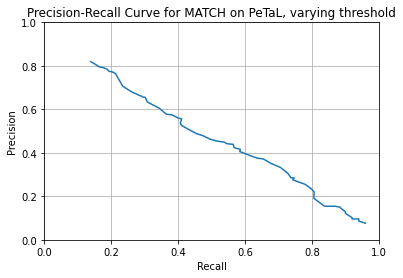

In [ ]:
plt.grid()
plt.title(f'Precision-Recall Curve for {MODEL} on {DATASET}, varying threshold')
plt.plot(ps, rs, linestyle='-')
plt.xlabel('Recall')
plt.xlim(0, 1)
plt.ylabel('Precision')
plt.ylim(0, 1)

if GENERATE_PLOTS:
    PLOT_PATH = os.path.join(PLOTS_PATH, f'prc_{MODEL}_{DATASET}.png')
    plt.savefig(fname=PLOT_PATH, facecolor='w', transparent=False)
    print(f"Your plot is saved as {PLOT_PATH}")

Your plot is saved as ../plots/20210701_173537_on_MAG_CS/prf1_MATCH_MAG.png


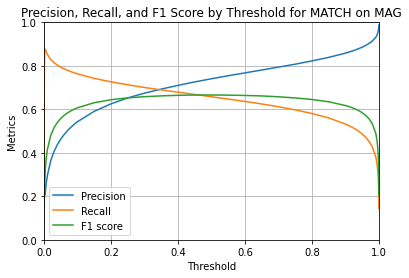

In [ ]:
plt.grid()
plt.title(f'Precision, Recall, and F1 Score by Threshold for {MODEL} on {DATASET}')
plt.plot(ts, ps, linestyle='-', label='Precision')
plt.plot(ts, rs, linestyle='-', label='Recall')
plt.plot(ts, f1s, linestyle='-', label='F1 score')
plt.xlabel('Threshold')
plt.xlim(0, 1)
plt.ylabel('Metrics')
plt.ylim(0, 1)
plt.legend()

if GENERATE_PLOTS:
    PLOT_PATH = os.path.join(PLOTS_PATH, f'prf1_{MODEL}_{DATASET}.png')
    plt.savefig(fname=PLOT_PATH, facecolor='w', transparent=False)
    print(f"Your plot is saved as {PLOT_PATH}")

Your plot is saved as ../plots/20210701_173537_on_MAG_CS/labels_MATCH_MAG.png


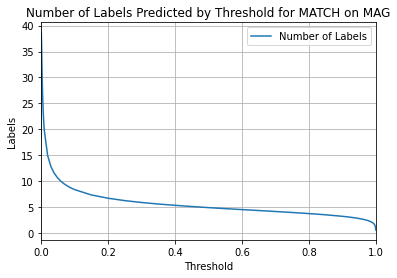

In [ ]:
plt.grid()
plt.title(f'Number of Labels Predicted by Threshold for {MODEL} on {DATASET}')
plt.plot(ts, topks, linestyle='-', label='Number of Labels')
plt.xlabel('Threshold')
plt.xlim(0, 1)
plt.ylabel('Labels')
plt.legend()

if GENERATE_PLOTS:
    PLOT_PATH = os.path.join(PLOTS_PATH, f'labels_{MODEL}_{DATASET}.png')
    plt.savefig(fname=PLOT_PATH, facecolor='w', transparent=False)
    print(f"Your plot is saved as {PLOT_PATH}")

## Additional analysis

In [ ]:
parent_labels = set()
with open('PeTaL/taxonomy.txt', 'r') as f:
    for line in f:
        labels = line.split()
        parent_labels.add(labels[0])

In [ ]:
parents = 0
total = 0
for labels in res_labels:
    for label in labels[:5]:
        total += 1
        if label in parent_labels:
            parents += 1
print(f"{parents} predicted labels out of {total}, or {parents / total :.3f}, are parent (non-leaf) labels.")

parents = 0
total = 0
for labels in test_labels:
    for label in labels:
        total += 1
        if label in parent_labels:
            parents += 1
print(f"{parents} target labels out of {total}, or {parents / total :.3f}, are parent (non-leaf) labels.")

294 predicted labels out of 500, or 0.588, are parent (non-leaf) labels.
257 target labels out of 458, or 0.561, are parent (non-leaf) labels.


In [ ]:
ks = list(range(1, 26))
pct_parents = []
for k in ks:
    parents = 0
    total = 0
    for labels in res_labels:
        for label in labels[:k]:
            total += 1
            if label in parent_labels:
                parents += 1
    pct_parents.append(parents / total)
    print(f"{parents} predicted labels out of {total}, or {parents / total :.3f}, are parent (non-leaf) labels.")   

76 predicted labels out of 100, or 0.760, are parent (non-leaf) labels.
156 predicted labels out of 200, or 0.780, are parent (non-leaf) labels.
200 predicted labels out of 300, or 0.667, are parent (non-leaf) labels.
249 predicted labels out of 400, or 0.623, are parent (non-leaf) labels.
294 predicted labels out of 500, or 0.588, are parent (non-leaf) labels.
323 predicted labels out of 600, or 0.538, are parent (non-leaf) labels.
347 predicted labels out of 700, or 0.496, are parent (non-leaf) labels.
383 predicted labels out of 800, or 0.479, are parent (non-leaf) labels.
420 predicted labels out of 900, or 0.467, are parent (non-leaf) labels.
459 predicted labels out of 1000, or 0.459, are parent (non-leaf) labels.
491 predicted labels out of 1100, or 0.446, are parent (non-leaf) labels.
515 predicted labels out of 1200, or 0.429, are parent (non-leaf) labels.
546 predicted labels out of 1300, or 0.420, are parent (non-leaf) labels.
575 predicted labels out of 1400, or 0.411, are 

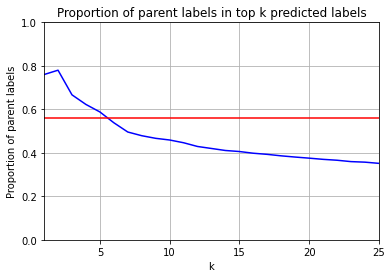

In [ ]:
plt.title("Proportion of parent labels in top k predicted labels")
plt.plot(ks, pct_parents, color='b', label="Predicted labels")
plt.xlim(1, 25)
plt.xlabel("k")
plt.ylim(0, 1)
plt.ylabel("Proportion of parent labels")
plt.grid()
plt.axhline(y=0.561, color='r')
plt.savefig(fname="are_parent_labels_overrepresented.png", facecolor='w', transparent=False)

## Generate confusion matrices

In [ ]:
k = 5

In [ ]:
test_labels

array([list(['chemically_modify_or_change_energy_state', 'chemically_assemble', 'self-assemble', 'chemically_assemble_organic_compounds']),
       list(['change_size_or_color', 'protect_from_harm', 'change_size/shape', 'protect_from_living_threats', 'protect_from_animals']),
       list(['process_resources', 'move', 'distribute_resources', 'store_resources', 'passive_movement', 'distribute_liquids', 'store_liquids', 'passively_move_through/on_solids']),
       list(['protect_from_harm', 'protect_from_non-living_threats', 'protect_from_temperature']),
       list(['move', 'physically_assemble/disassemble', 'maintain_structural_integrity', 'change_size_or_color', 'optimize_shape/materials', 'physically_assemble_structure', 'active_movement', 'passive_movement', 'prevent_structural_failure', 'manage_structural_forces', 'change_size/shape', 'actively_move_through_gases', 'passively_move_through_gases', 'prevent_deformation', 'prevent_fracture/rupture', 'manage_stress/strain']),
       list

In [ ]:
# top_res_labels = res_labels[:,:k]
threshold = 0.1
# np.argmax(res_score < threshold) becomes the number of labels scoring above the threshold
top_res_labels = np.array(list(res_label[:np.argmax(res_score < threshold)] for res_label, res_score in zip(res_labels, res_scores)))
top_res_labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


array([array(['maintain_structural_integrity', 'change_size_or_color',
       'manage_structural_forces', 'change_size/shape', 'manage_wear',
       'prevent_structural_failure', 'physically_assemble/disassemble',
       'attach', 'physically_assemble_structure'], dtype=object),
       array(['manage_structural_forces', 'maintain_structural_integrity',
       'physically_assemble/disassemble', 'manage_stress/strain',
       'chemically_modify_or_change_energy_state',
       'optimize_shape/materials'], dtype=object),
       array(['maintain_structural_integrity', 'manage_structural_forces',
       'physically_assemble/disassemble'], dtype=object),
       array(['protect_from_non-living_threats', 'protect_from_harm',
       'protect_from_temperature', 'physically_assemble/disassemble'],
      dtype=object),
       array(['physically_assemble/disassemble',
       'sense_send_or_process_information', 'optimize_shape/materials'],
      dtype=object),
       array(['chemically_modify_or_cha

In [ ]:
all_labels = np.concatenate([train_labels, test_labels], axis=0)
labels = np.array(list(set(label for label_list in all_labels for label in label_list)))

label2idx = {label: idx for idx, label in enumerate(labels)}
idx2label = {idx: label for idx, label in enumerate(labels)}

In [ ]:
mlb = MultiLabelBinarizer(sparse_output=False, classes=labels)
res_sparse = mlb.fit_transform(top_res_labels)
test_sparse = mlb.fit_transform(test_labels)
MCM = multilabel_confusion_matrix(test_sparse, res_sparse, labels=[label2idx[label] for label in labels])

In [ ]:
MCM.shape

(130, 2, 2)

In [ ]:
# a confusion matrix
# [[TN FN]
#  [FP TP]]

print("CONFUSION MATRIX FORMAT:\n[[true_negatives  false_negatives]\n [false_positives true_positives ]]")
for idx, matrix in enumerate(MCM):
    print(idx2label[idx])
    print(matrix)

CONFUSION MATRIX FORMAT:
[[true_negatives  false_negatives]
 [false_positives true_positives ]]
protect_from_non-living_threats
[[46 35]
 [ 4 15]]
manage_environmental_disturbances
[[98  0]
 [ 2  0]]
prevent_fatigue
[[100   0]
 [  0   0]]
sense_disease
[[100   0]
 [  0   0]]
protect_from_loss_of_liquids
[[96  0]
 [ 4  0]]
modify/convert_mechanical_energy
[[99  0]
 [ 1  0]]
passively_move_through/on_liquids
[[97  0]
 [ 3  0]]
sense_shape_and/or_pattern
[[98  0]
 [ 2  0]]
send_signals
[[91  5]
 [ 2  2]]
store_resources
[[96  0]
 [ 4  0]]
send_light_signals_in_the_non-visible_spectrum
[[100   0]
 [  0   0]]
protect_from_harm
[[33 35]
 [ 7 25]]
distribute_solids
[[97  0]
 [ 3  0]]
chemically_modify_or_change_energy_state
[[82 12]
 [ 5  1]]
store_energy
[[99  0]
 [ 1  0]]
protect_from_living_threats
[[80  5]
 [10  5]]
expel_liquids
[[100   0]
 [  0   0]]
manage_environmental_disturbances_in_a_community
[[100   0]
 [  0   0]]
actively_move_through/on_solids
[[96  1]
 [ 3  0]]
protect_from_an

In [ ]:
confmat_data = [(idx, idx2label[idx], matrix[0][0], matrix[0][1], matrix[1][0], matrix[1][1]) for idx, matrix in enumerate(MCM)]
columns = ['index', 'label', 'TN', 'FN', 'FP', 'TP']
confmat_df = pd.DataFrame(confmat_data, columns=columns)

In [ ]:
confmat_df

[0.3684210526315789,
 0.5,
 0.0,
 0.0,
 0.25,
 1.0,
 0.3333333333333333,
 0.0,
 0.75,
 0.0,
 0.0,
 0.5,
 0.3333333333333333,
 0.5,
 0.0,
 0.5333333333333333,
 0.0,
 0.0,
 0.3333333333333333,
 0.5,
 0.0,
 0.0,
 0.6,
 0.4,
 0.0,
 0.5882352941176471,
 0.0,
 0.45454545454545453,
 0.0,
 0.0,
 0.5,
 0.6666666666666666,
 0.0,
 0.42857142857142855,
 0.0,
 0.25,
 0.75,
 0.5,
 0.0,
 0.16666666666666666,
 0.8888888888888888,
 0.5,
 0.5555555555555556,
 0.3333333333333333,
 0.4,
 0.6153846153846154,
 0.14285714285714285,
 0.0,
 0.0,
 0.0,
 0.7777777777777778,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.5,
 0.0,
 0.4375,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.5,
 1.0,
 0.6,
 0.0,
 0.0,
 0.25,
 0.2222222222222222,
 0.0,
 0.6666666666666666,
 0.3333333333333333,
 0.6,
 0.0,
 0.0,
 0.75,
 0.0,
 0.8333333333333334,
 1.0,
 1.0,
 0.0,
 0.625,
 0.5,
 0.1111111111111111,
 0.0,
 0.0,
 0.3333333333333333,
 0.5,
 0.0,
 0.0,
 0.42857142857142855,
 0.0,
 1.0,
 0.5,
 0.0,
 1.0,
 0.0,
 0.0,
 0.16666666666666666,
 0.66666666

In [ ]:
confmat_df[['precision']] = confmat_df.apply(
    lambda row: 0 if (row['TP'] + row['FP']) == 0 else (row['TP'] / (row['TP'] + row['FP'])),
    axis=1
)

## New confusion matrix work

In [ ]:
# top_res_labels = res_labels[:,:k]
threshold = 0.1
# np.argmax(res_score < threshold) becomes the number of labels scoring above the threshold
top_res_labels = np.array(list(res_label[:np.argmax(res_score < threshold)] for res_label, res_score in zip(res_labels, res_scores)))
top_res_labels

array([array(['maintain_ecological_community', 'individual_benefit',
       'coordinate_by_self-organization'], dtype=object),
       array(['protect_from_harm', 'protect_from_living_threats',
       'protect_from_animals'], dtype=object),
       array(['chemically_modify_or_change_energy_state', 'change_energy_state',
       'protect_from_harm', 'protect_from_non-living_threats',
       'self-assemble', 'modify/convert_thermal_energy',
       'protect_from_light', 'chemically_assemble'], dtype=object),
       array(['physically_assemble/disassemble', 'protect_from_light',
       'camouflage/mimicry'], dtype=object),
       array(['move', 'active_movement', 'move_through/on_liquids',
       'actively_move_through/on_solids'], dtype=object),
       array(['modify_color', 'change_structural_color', 'change_size_or_color',
       'sense_temperature_cues', 'camouflage/mimicry',
       'sense_send_or_process_information'], dtype=object),
       array(['capture_solids', 'capture_resources', 

In [ ]:
parent_labels = set()
with open(f'{DATASET}/taxonomy.txt', 'r') as tax_file:
    for line in tax_file:
        parent_label = line.split()[0]
        parent_labels.add(parent_label)
len(parent_labels)

30

In [ ]:
all_labels = np.concatenate([train_labels, test_labels], axis=0)

label_count = dict()
for label in label2idx:
    label_count[label] = 0

for label_list in all_labels:
    for label in label_list:
        label_count[label] += 1

labels = np.array(sorted(list(set(label for label_list in all_labels for label in label_list)), 
                         key=lambda lbl: label_count[lbl],
                         reverse=True))

label2idx = {label: idx for idx, label in enumerate(labels)}
idx2label = {idx: label for idx, label in enumerate(labels)}

In [ ]:
preds_for_test_label = dict()
test_label_count = dict()

for test_label in label2idx:
    test_label_count[test_label] = 0

for test_label in label2idx:
    preds_for_test_label[test_label] = dict()
    for res_label in label2idx:
        preds_for_test_label[test_label][res_label] = 0

for test_label_list, res_label_list, res_score_list in zip(test_labels, res_labels, res_scores):
    for test_label in test_label_list:
        test_label_count[test_label] += 1
        for res_label, res_score in zip(res_label_list, res_score_list):
            preds_for_test_label[test_label][res_label] += res_score

    # print("test_label_list", test_label_list)
    # print("top_res_label_list", top_res_label_list)

In [ ]:
num_labels = len(label2idx)
conf_matrix = np.array(
    [
     [
      # i is label2idx[test_label], j is label2idx[res_label]
      preds_for_test_label[idx2label[i]][idx2label[j]] / test_label_count[idx2label[i]] if test_label_count[idx2label[i]] > 0 else 0
      for j in range(num_labels)
     ]
     for i in range(num_labels)
    ]
    
)


In [ ]:
conf_matrix

array([[1.06862731e-01, 1.93774622e-06, 1.20991410e-06, ...,
        3.18792951e-03, 4.54858025e-07, 2.87015806e-03],
       [2.08876503e-04, 1.23323936e-01, 2.67598570e-01, ...,
        5.31033203e-04, 2.16453239e-03, 5.12192580e-04],
       [4.90042089e-03, 2.18420170e-04, 6.56346688e-01, ...,
        8.81436987e-06, 7.89089444e-04, 1.22590940e-03],
       ...,
       [2.47102114e-04, 6.74900599e-04, 2.07476605e-05, ...,
        1.17424550e-03, 6.34728512e-03, 2.40133442e-02],
       [4.74291301e-04, 2.27344758e-03, 3.53760765e-06, ...,
        2.12665251e-03, 4.20049252e-03, 2.90913926e-03],
       [2.72550807e-03, 1.21996167e-04, 1.93961207e-03, ...,
        1.53924108e-04, 1.00869208e-04, 7.53613810e-01]])

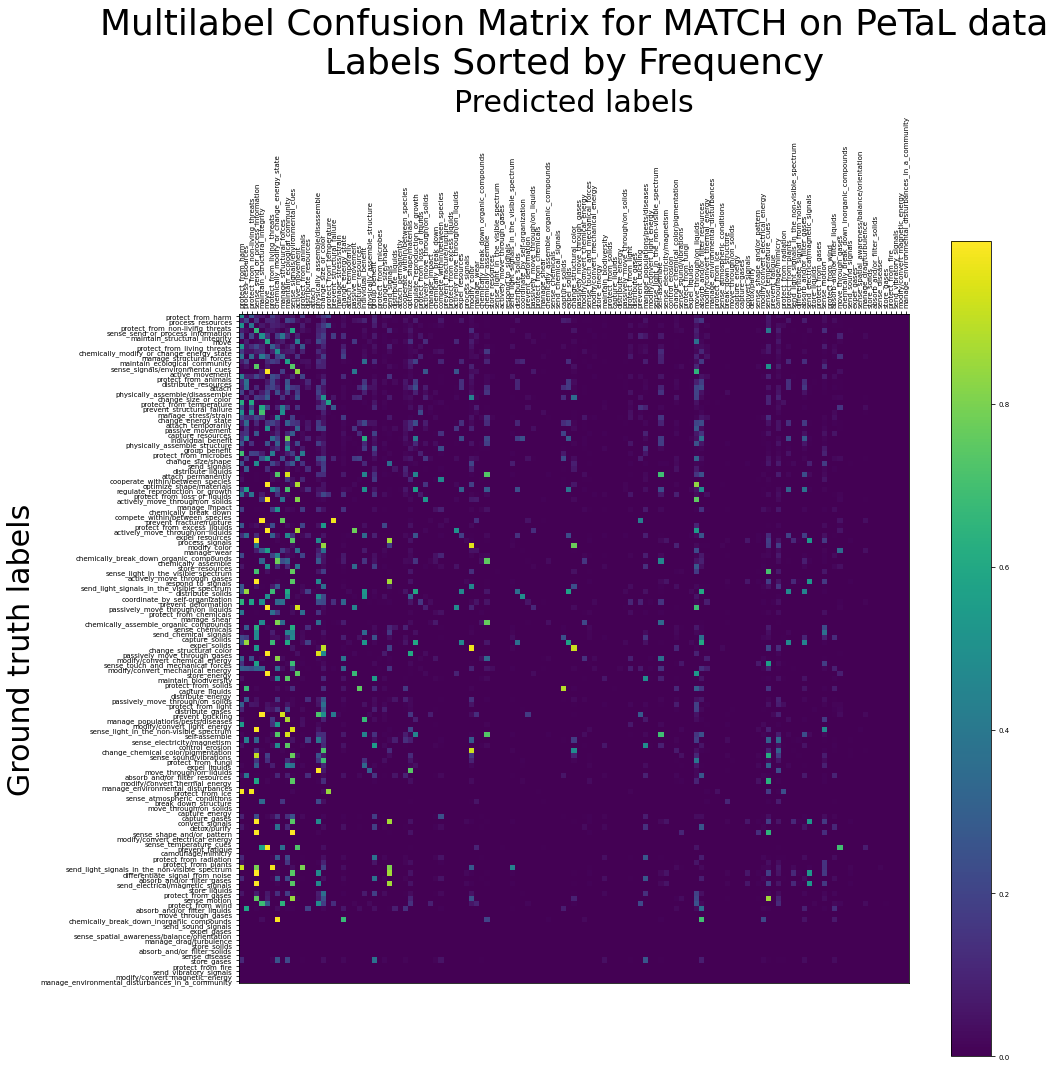

In [ ]:
rc('xtick', labelsize=7)
rc('ytick', labelsize=7)
rc('font', size=30)

label_limit = 131
conf_matrix_small = conf_matrix[:label_limit, :label_limit]
num_labels = label_limit
row_labels = [idx2label[i] for i in range(num_labels)]
col_labels = [idx2label[i] for i in range(num_labels)]

plt.rcParams["figure.figsize"] = (15, 15)
fig, ax = plt.subplots()
plt.matshow(conf_matrix_small, fignum=0)
ax.set_title('Multilabel Confusion Matrix for MATCH on PeTaL data\nLabels Sorted by Frequency', y=1.0, pad=15)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Ground truth labels')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(range(num_labels), col_labels, rotation='vertical')
plt.yticks(range(num_labels), row_labels)
plt.colorbar()
# plt.rcParams["axes.titley"] = 1.0
# plt.rcParams["axes.titlepad"] = 15
plt.savefig(fname='../plots/mcm_20210721.jpg', facecolor='w', transparent=False)

In [ ]:
from matplotlib import pyplot as plt
matplotlib.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [ ]:
len(idx2label)

131

Only Leaf Labels

In [ ]:
all_labels = np.concatenate([train_labels, test_labels], axis=0)

label_count = dict()
for label in label2idx:
    label_count[label] = 0

for label_list in all_labels:
    for label in label_list:
        label_count[label] += 1

labels = np.array(sorted(filter(lambda lbl: not lbl in parent_labels, 
                                list(set(label for label_list in all_labels for label in label_list))
                                ), 
                         key=lambda lbl: label_count[lbl],
                         reverse=True))

label2idx = {label: idx for idx, label in enumerate(labels)}
idx2label = {idx: label for idx, label in enumerate(labels)}

In [ ]:
preds_for_test_label = dict()
test_label_count = dict()

for test_label in label2idx:
    test_label_count[test_label] = 0

for test_label in label2idx:
    preds_for_test_label[test_label] = dict()
    for res_label in label2idx:
        preds_for_test_label[test_label][res_label] = 0

for test_label_list, res_label_list, res_score_list in zip(test_labels, res_labels, res_scores):
    for test_label in test_label_list:
        if test_label in test_label_count:
            test_label_count[test_label] += 1
            for res_label, res_score in zip(res_label_list, res_score_list):
                if res_label in preds_for_test_label[test_label]:
                    preds_for_test_label[test_label][res_label] += res_score

    # print("test_label_list", test_label_list)
    # print("top_res_label_list", top_res_label_list)

In [ ]:
num_labels = len(label2idx)
conf_matrix = np.array(
    [
     [
      # i is label2idx[test_label], j is label2idx[res_label]
      preds_for_test_label[idx2label[i]][idx2label[j]] / test_label_count[idx2label[i]] if test_label_count[idx2label[i]] > 0 else 0
      for j in range(num_labels)
     ]
     for i in range(num_labels)
    ]
    
)


In [ ]:
conf_matrix

array([[6.56346688e-01, 4.29144085e-02, 1.21169718e-03, ...,
        0.00000000e+00, 1.05987926e-04, 0.00000000e+00],
       [2.12336512e-01, 2.06630436e-01, 5.94522079e-04, ...,
        0.00000000e+00, 7.06466681e-05, 0.00000000e+00],
       [1.24448915e-02, 4.64475734e-04, 5.72234418e-01, ...,
        0.00000000e+00, 8.27193056e-07, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

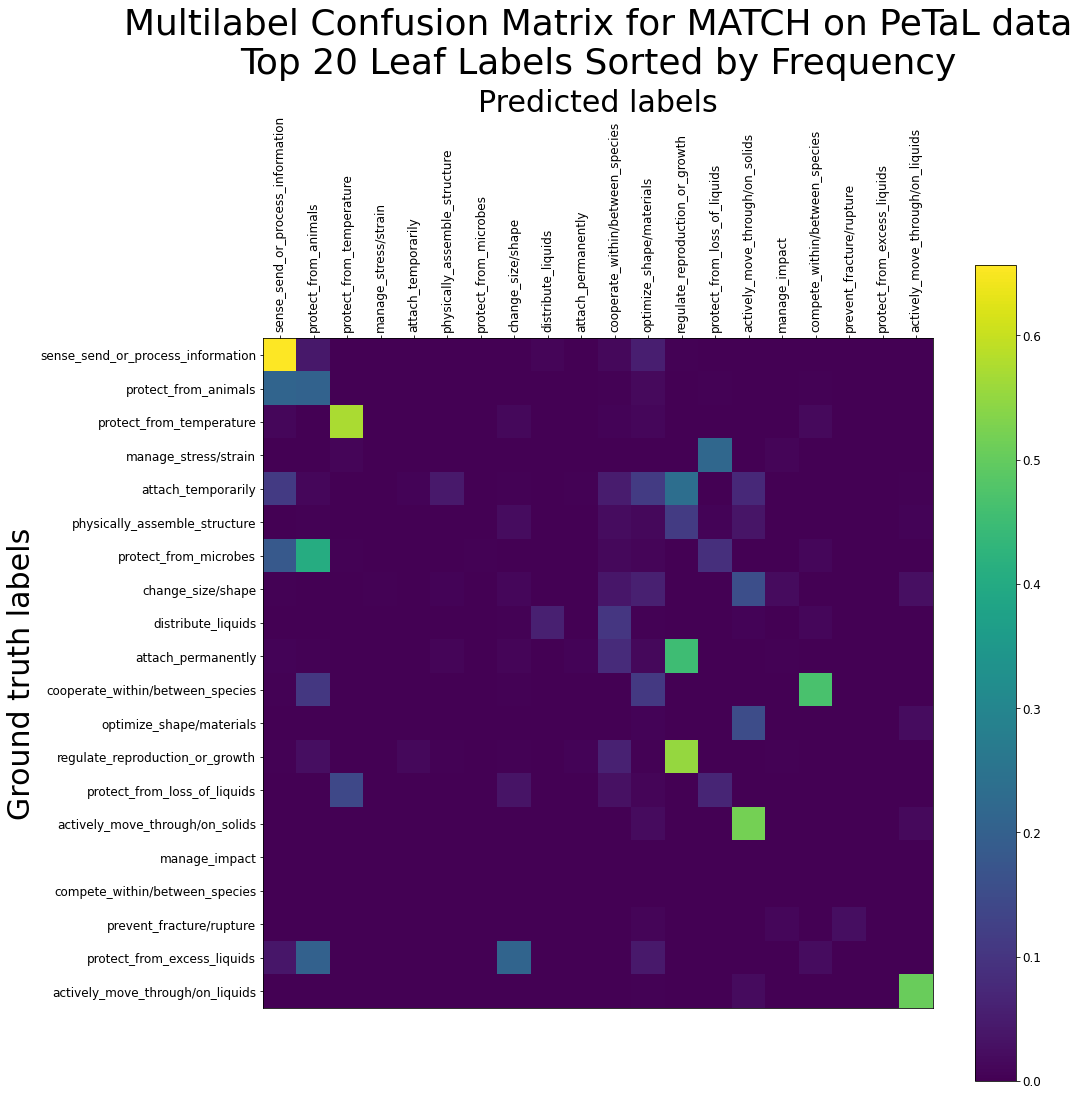

In [ ]:
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('font', size=30)

label_limit = 20
conf_matrix_small = conf_matrix[:label_limit, :label_limit]
num_labels = label_limit
row_labels = [idx2label[i] for i in range(num_labels)]
col_labels = [idx2label[i] for i in range(num_labels)]

plt.rcParams["figure.figsize"] = (15, 15)
fig, ax = plt.subplots()
plt.matshow(conf_matrix_small, fignum=0)
ax.set_title('Multilabel Confusion Matrix for MATCH on PeTaL data\nTop 20 Leaf Labels Sorted by Frequency', y=1.0, pad=15)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Ground truth labels')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.xticks(range(num_labels), col_labels, rotation='vertical')
plt.yticks(range(num_labels), row_labels)
plt.colorbar()
# plt.rcParams["axes.titley"] = 1.0
# plt.rcParams["axes.titlepad"] = 15
plt.savefig(fname='../plots/mcm_20210721.jpg', facecolor='w', transparent=False)

# Previous work (ignore)

In [ ]:
!wc predictions.txt
!wc MAG/test_labels.txt

  70533  352665 3367234 predictions.txt
  70533  394260 3763878 MAG/test_labels.txt


In [ ]:
!head -n 50 predictions.txt
print("\n")
!head -n 50 MAG/test_labels.txt

204321447 2474386 195324797 60048249 206134035
66402592 2776509796 136764020 204321447 44572571
2780522230 28490314 204321447 89600930 178980831
203005215 204321447 2777530160 24687705 76482347
2781297728 154945302 31972630 81074085 19966478
167343916 90509273 500300565 65401140 207987634
74294265 156996364 31258907 192126672 120314980
61423126 199360897 193702766 169590947 48044578
11413529 156996364 124851039 54956558 31258907
139722471 104267543 84462506 28490314 198386975
194969405 152086174 31972630 49774154 107457646
178980831 52622490 2779883129 78201319 31972630
555944384 73836528 60069766 6832461 179799912
101738243 50644808 178980831 119857082 154945302
90509273 65401140 31972630 19966478 94915269
31258907 204739117 47318570 120314980 9659607
2400350 57273362 157125643 204397858 173801870
199360897 202973057 169590947 529173508 2781009160
2776224158 204321447 203005215 91559456 2778121359
31972630 71134354 124504099 178980831 9417928
81978471 31258907 105344744 2776362087 476

In [ ]:
pred_path = "predictions.txt"
test_path = "MAG/test_labels.txt"

In [ ]:
# TO DO: compute precision, recall, F1 score, confusion matrix

In [ ]:
rows_list = []
with open(pred_path, 'r') as pred_fn, open(test_path, 'r') as test_fn:
    for pred_line, test_line in zip(pred_fn, test_fn):
        pred_labels = [int(label) for label in pred_line.strip().split()]
        test_labels = [int(label) for label in test_line.strip().split()]
        dict1 = {'pred_labels': pred_labels, 'test_labels': test_labels}
        rows_list.append(dict1)
label_df = pd.DataFrame(rows_list)
label_df

,pred_labels,test_labels
0,"[204321447, 2474386, 195324797, 60048249, 2061...","[60048249, 206134035, 2474386, 165297611, 1953..."
1,"[66402592, 2776509796, 136764020, 204321447, 4...","[2776509796, 44572571, 108827166, 136764020, 6..."
2,"[2780522230, 28490314, 204321447, 89600930, 17...","[204321447, 89600930, 2780522230, 178980831, 2..."
3,"[203005215, 204321447, 2777530160, 24687705, 7...","[24687705, 53893814, 76482347, 2777530160, 203..."
4,"[2781297728, 154945302, 31972630, 81074085, 19...","[119857082, 2781297728, 107457646, 2777036941,..."
...,...,...
70528,"[50644808, 39890363, 37736160, 119857082, 1549...","[119857082, 50644808, 39890363, 37736160, 1085..."
70529,"[31972630, 109950114, 181844469, 141379421, 14...","[55439883, 141268832, 121684516, 141379421, 31..."
70530,"[65647387, 124101348, 77088390, 118930307, 157...","[124101348, 192028432, 99016210, 65647387, 542..."
70531,"[132829578, 2780368719, 56739046, 544833334, 4...","[2780368719, 135641252, 544833334, 80944243, 4..."


In [ ]:
label_df['pred_labels'][1]

[66402592, 2776509796, 136764020, 204321447, 44572571]

In [ ]:
def calc_precision():
    tp = 0
    tp_fp = 0
    for index, row in label_df.iterrows():
        pred_labels, test_labels = row['pred_labels'], row['test_labels']
        tp_fp += 1
        if pred_labels[0] in test_labels:
            tp += 1
        # for pred_label in pred_labels:
        #     if pred_label in test_labels:
        #         true_positives += 1
    return tp / tp_fp


In [ ]:
print(f"Precision @ 1: {calc_precision()}")

Precision @ 1: 0.9148909021309174


In [ ]:
def calc_recall():
    tp = 0
    tp_fn = 0
    for index, row in label_df.iterrows():
        pred_labels, test_labels = row['pred_labels'], row['test_labels']
        for test_label in test_labels:
            tp_fn += 1
            if test_label in pred_labels:
                tp += 1
    return tp / tp_fn

In [ ]:
print(f"Recall @ 5: {calc_recall()}")

Recall @ 5: 0.5718180895855527


## Custom calculation of precision and recall.

In [ ]:
res_labels = np.load(f"{DATASET}/results/{MODEL}-{DATASET}-labels.npy")
res_scores = np.load(f"{DATASET}/results/{MODEL}-{DATASET}-scores.npy")

In [ ]:
test_labels = np.load(f"{DATASET}/test_labels.npy")

In [ ]:
Stats = namedtuple("Stats", "threshold topk precision recall f1")

def compute_stats(threshold):
    precisions = []
    recalls = []
    topks = []
    f1s = []
    for res_label, res_score, test_label in zip(res_labels, res_scores, test_labels):
        topk = np.argmax(res_score < threshold) # topk becomes the number of labels scoring above the threshold
        precision = 1.0 if topk == 0 else np.mean([1 if x in test_label else 0 for x in res_label[:topk]])
        recall = np.mean([1 if x in res_label[:topk] else 0 for x in test_label])
        f1 = 0 if (precision + recall) == 0 else (2 * precision * recall) / (precision + recall)
        topks.append(topk)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        # print(res_label[:topk], precision, recall)
    return Stats(threshold, np.mean(topks), np.mean(precisions), np.mean(recalls), np.mean(f1s))
    # print("Threshold:", threshold)
    # print("Average number of labels:", np.mean(topks))
    # print("Average precision:", np.mean(precisions))
    # print("Average recall:", np.mean(recalls))
    # print("Average F1 score:", np.mean(f1s))

In [ ]:
compute_stats(0.5)

Stats(threshold=0.5, topk=3.01, precision=0.5076904761904761, recall=0.37694455544455535, f1=0.3846569264069264)

In [ ]:
ps = []
rs = []
ts = []
f1s = []
for i in tqdm(range(1, 10000)):
    threshold = i / 10000
    stats = compute_stats(threshold)
    ps.append(stats.precision)
    rs.append(stats.recall)
    ts.append(threshold)
    f1s.append(stats.f1)

100%|██████████| 9999/9999 [02:05<00:00, 79.57it/s]


(0.0, 1.0)

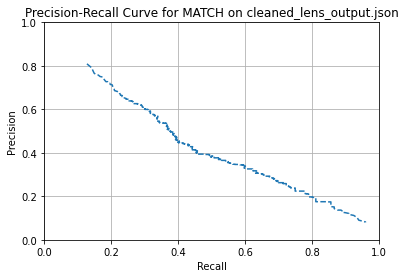

In [ ]:
plt.plot(ps, rs, linestyle='--')
plt.grid()
plt.title('Precision-Recall Curve for MATCH on cleaned_lens_output.json')
plt.xlabel('Recall')
plt.xlim(0, 1)
plt.ylabel('Precision')
plt.ylim(0, 1)

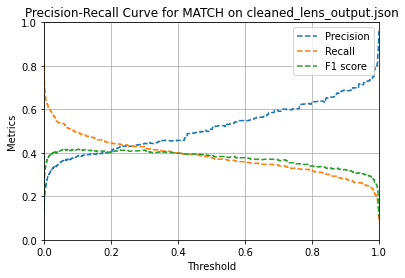

In [ ]:
plt.grid()
plt.title('Precision-Recall Curve for MATCH on cleaned_lens_output.json')
plt.plot(ts, ps, linestyle='--', label='Precision')
plt.plot(ts, rs, linestyle='--', label='Recall')
plt.plot(ts, f1s, linestyle='--', label='F1 score')
plt.xlabel('Threshold')
plt.xlim(0, 1)
plt.ylabel('Metrics')
plt.ylim(0, 1)
plt.legend()

### Compute similar statistics for MAG-CS dataset

In [ ]:
DATASET = 'MAG'

res_labels = np.load(f"{DATASET}/results/{MODEL}-{DATASET}-labels.npy")
res_scores = np.load(f"{DATASET}/results/{MODEL}-{DATASET}-scores.npy")
test_labels = np.load(f"{DATASET}/test_labels.npy")

In [ ]:
thresholds = list(x / 1000 for x in range(1, 10)) + \
    list(x / 100 for x in range(1, 10)) + \
    list(x / 10 for x in range(1, 10)) + \
    list((90 + x) / 100 for x in range(1, 10)) + \
    list((990 + x) / 1000 for x in range(1, 10))

In [ ]:
ps = []
rs = []
ts = []
f1s = []
for i in tqdm(thresholds):
    threshold = i / 100
    stats = compute_stats(threshold)
    ps.append(stats.precision)
    rs.append(stats.recall)
    ts.append(threshold)
    f1s.append(stats.f1)

100%|██████████| 45/45 [07:07<00:00,  9.72s/it]


(0.0, 1.0)

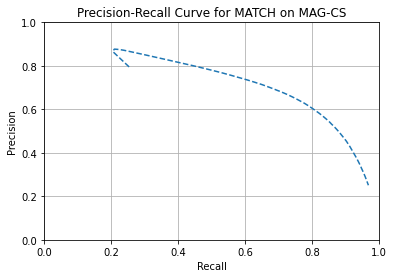

In [ ]:
plt.plot(ps, rs, linestyle='--')
plt.grid()
plt.title('Precision-Recall Curve for MATCH on MAG-CS')
plt.xlabel('Recall')
plt.xlim(0, 1)
plt.ylabel('Precision')
plt.ylim(0, 1)

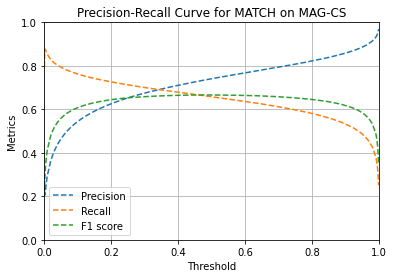

In [ ]:
plt.grid()
plt.title('Precision-Recall Curve for MATCH on MAG-CS')
plt.plot(ts, ps, linestyle='--', label='Precision')
plt.plot(ts, rs, linestyle='--', label='Recall')
plt.plot(ts, f1s, linestyle='--', label='F1 score')
plt.xlabel('Threshold')
plt.xlim(0, 1)
plt.ylabel('Metrics')
plt.ylim(0, 1)
plt.legend()